In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward(self.theta_b, Xt)
            b_plus = self.b_forward(theta, Xt)
        else:
            b_minus  = self.b_backward(theta, Xt)
            b_plus = self.b_forward(self.theta_f, Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        
        if np.isnan(cross_entropy).any() :
            import pdb; pdb.set_trace()

        J = np.mean(cross_entropy  )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

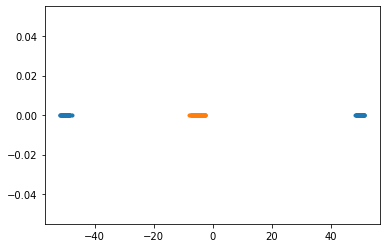

In [7]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) +50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) - 50
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [8]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.001, weights=[500])

loss b 25096.79296875
loss f 11.257397651672363
loss b 23258.31640625
loss f 11.233646392822266
loss b 21327.7265625
loss f 11.11867904663086
loss b 19472.849609375
loss f 11.007210731506348
loss b 17645.966796875
loss f 10.868178367614746
loss b 15895.94921875
loss f 10.78911018371582
loss b 14368.091796875
loss f 10.661018371582031
loss b 12937.1396484375
loss f 10.463540077209473
loss b 11583.416015625
loss f 10.341631889343262
loss b 10403.5947265625
loss f 10.136663436889648
loss b 9355.3486328125
loss f 9.9758939743042
loss b 8400.2001953125
loss f 9.771241188049316
loss b 7561.1689453125
loss f 9.52892780303955
loss b 6816.470703125
loss f 9.319753646850586
loss b 6192.419921875
loss f 9.081907272338867
loss b 5579.62255859375
loss f 8.841097831726074
loss b 5027.68310546875
loss f 8.57263469696045
loss b 4589.37890625
loss f 8.309814453125
loss b 4198.9951171875
loss f 7.987634181976318
loss b 3807.167724609375
loss f 7.684337615966797
loss b 3476.64501953125
loss f 7.332781314

loss b 176.6298065185547
loss f 3.1908493041992188
loss b 178.27488708496094
loss f 3.223172664642334
loss b 174.45278930664062
loss f 3.183729887008667
loss b 174.51480102539062
loss f 3.18135929107666
loss b 172.05982971191406
loss f 3.181220293045044
loss b 171.1527557373047
loss f 3.1825923919677734
loss b 170.57675170898438
loss f 3.1989030838012695
loss b 165.0162353515625
loss f 3.18611478805542
loss b 169.0711669921875
loss f 3.1699376106262207
loss b 166.67596435546875
loss f 3.1762707233428955
loss b 162.29843139648438
loss f 3.1862473487854004
loss b 167.3743896484375
loss f 3.1658506393432617
loss b 162.9392547607422
loss f 3.1951448917388916
loss b 161.8258819580078
loss f 3.166395664215088
loss b 161.82662963867188
loss f 3.1708250045776367
loss b 162.9136199951172
loss f 3.190758466720581
loss b 156.69650268554688
loss f 3.1768569946289062
loss b 156.5540008544922
loss f 3.172713279724121
loss b 160.7501678466797
loss f 3.1611995697021484
loss b 156.59561157226562
loss f

loss f 3.150597333908081
loss b 84.0834732055664
loss f 3.1437456607818604
loss b 81.22331237792969
loss f 3.1453983783721924
loss b 82.87194061279297
loss f 3.1533262729644775
loss b 83.55522155761719
loss f 3.141202211380005
loss b 80.03678894042969
loss f 3.152238368988037
loss b 82.13191986083984
loss f 3.1368446350097656
loss b 81.18452453613281
loss f 3.1553163528442383
loss b 79.98284149169922
loss f 3.1320009231567383
loss b 81.7104263305664
loss f 3.148158311843872
loss b 78.82695770263672
loss f 3.1421945095062256
loss b 82.0641098022461
loss f 3.151689291000366
loss b 79.47322845458984
loss f 3.165675640106201
loss b 80.5141372680664
loss f 3.1569807529449463
loss b 80.84609985351562
loss f 3.138549566268921
loss b 79.48295593261719
loss f 3.134237766265869
loss b 78.3466796875
loss f 3.141937732696533
loss b 78.14923095703125
loss f 3.130688190460205
loss b 79.12403869628906
loss f 3.155149459838867
loss b 77.00322723388672
loss f 3.1458284854888916
loss b 79.2723388671875


loss b 52.769649505615234
loss f 3.1258859634399414
loss b 53.148101806640625
loss f 3.118415355682373
loss b 54.395320892333984
loss f 3.131309986114502
loss b 53.26490020751953
loss f 3.121633768081665
loss b 52.98490524291992
loss f 3.1166820526123047
loss b 54.029075622558594
loss f 3.1288223266601562
loss b 53.452083587646484
loss f 3.113295793533325
loss b 51.284889221191406
loss f 3.112243413925171
loss b 53.037357330322266
loss f 3.126216411590576
loss b 51.71355438232422
loss f 3.1008028984069824
loss b 52.54261779785156
loss f 3.1306674480438232
loss b 52.81157302856445
loss f 3.130221366882324
loss b 53.28444290161133
loss f 3.1154839992523193
loss b 52.220123291015625
loss f 3.111330270767212
loss b 52.45466613769531
loss f 3.1106619834899902
loss b 52.83695602416992
loss f 3.1250433921813965
loss b 50.81392288208008
loss f 3.11635160446167
loss b 51.07355880737305
loss f 3.126570463180542
loss b 50.03251266479492
loss f 3.119816541671753
loss b 52.29436492919922
loss f 3.1

loss b 40.52188491821289
loss f 3.0808372497558594
loss b 39.15468215942383
loss f 3.078887939453125
loss b 40.576560974121094
loss f 3.110330581665039
loss b 39.31400680541992
loss f 3.1005988121032715
loss b 40.34273147583008
loss f 3.0829436779022217
loss b 39.98003387451172
loss f 3.0952372550964355
loss b 39.01111602783203
loss f 3.101741313934326
loss b 40.14735794067383
loss f 3.0975122451782227
loss b 39.07243347167969
loss f 3.090935707092285
loss b 39.484195709228516
loss f 3.0992817878723145
loss b 40.83216857910156
loss f 3.1002962589263916
loss b 39.504302978515625
loss f 3.087028741836548
loss b 39.39999771118164
loss f 3.105910539627075
loss b 40.394859313964844
loss f 3.099106550216675
loss b 39.39475631713867
loss f 3.1050169467926025
loss b 38.334022521972656
loss f 3.0823962688446045
loss b 40.07011413574219
loss f 3.087618589401245
loss b 38.93815612792969
loss f 3.084050178527832
loss b 40.26905059814453
loss f 3.083625555038452
loss b 38.76825714111328
loss f 3.10

loss f 3.0658512115478516
loss b 32.751102447509766
loss f 3.0696332454681396
loss b 32.284996032714844
loss f 3.066338539123535
loss b 32.23430252075195
loss f 3.0762932300567627
loss b 32.76473617553711
loss f 3.077683687210083
loss b 33.3941650390625
loss f 3.0713093280792236
loss b 32.61356735229492
loss f 3.075538158416748
loss b 32.65862274169922
loss f 3.06209135055542
loss b 32.38770294189453
loss f 3.074493885040283
loss b 32.03400421142578
loss f 3.0753982067108154
loss b 32.15597152709961
loss f 3.0691025257110596
loss b 31.896577835083008
loss f 3.0729048252105713
loss b 32.252567291259766
loss f 3.0755951404571533
loss b 33.01997375488281
loss f 3.063976526260376
loss b 31.363807678222656
loss f 3.0675973892211914
loss b 32.01131057739258
loss f 3.0850439071655273
loss b 31.2559871673584
loss f 3.0685482025146484
loss b 31.542593002319336
loss f 3.0540335178375244
loss b 31.82399559020996
loss f 3.08307147026062
loss b 31.80732536315918
loss f 3.0622990131378174
loss b 31.

loss f 3.040529251098633
loss b 26.303497314453125
loss f 3.0525436401367188
loss b 27.177536010742188
loss f 3.0522148609161377
loss b 27.01054573059082
loss f 3.0581092834472656
loss b 26.608095169067383
loss f 3.037874698638916
loss b 26.88115692138672
loss f 3.0423948764801025
loss b 26.59652328491211
loss f 3.051769971847534
loss b 27.044208526611328
loss f 3.0549235343933105
loss b 26.78223419189453
loss f 3.0499162673950195
loss b 27.025386810302734
loss f 3.057065010070801
loss b 27.220272064208984
loss f 3.053480863571167
loss b 26.2409610748291
loss f 3.0470657348632812
loss b 27.115713119506836
loss f 3.047943115234375
loss b 26.14078712463379
loss f 3.0221540927886963
loss b 26.888317108154297
loss f 3.043203592300415
loss b 25.10542106628418
loss f 3.0408236980438232
loss b 27.20466423034668
loss f 3.036555528640747
loss b 26.799226760864258
loss f 3.0576090812683105
loss b 26.546161651611328
loss f 3.0454602241516113
loss b 26.811660766601562
loss f 3.0496864318847656
los

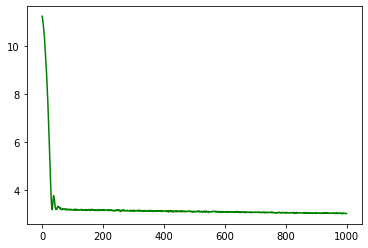

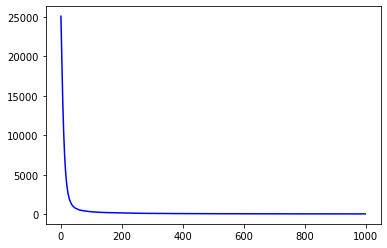

In [9]:
c.fit(1000,1)

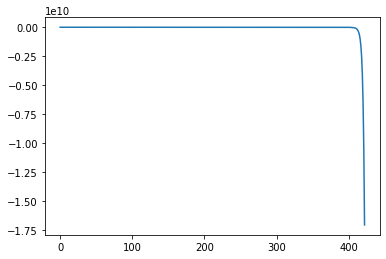

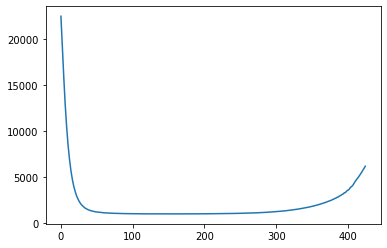

In [6]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

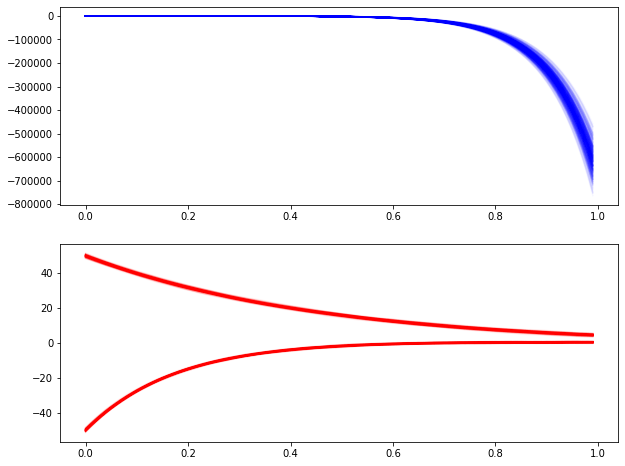

In [7]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [ ]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [ ]:
batch_terminal_empirical_b = next(c.data_stream(False))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")